In [137]:
from __future__ import print_function 
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10

# Load CIFAR 10 dataset
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Tạo một tập validation từ X_train 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 1000)
# print('(New) X_train shape = ', X_train.shape)
# print('X_val shape         = ', X_val.shape)

# Feature engineering 
# mean image of all training images
img_mean = np.mean(X_train, axis = 0)

def feature_engineering(X):
    X -= img_mean # zero-centered
    N = X.shape[0] # number of data point 
    X = X.reshape(N, -1) # vectorizetion 
    return np.concatenate((X, np.ones((N, 1))), axis = 1) # bias trick 

X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

print('X_train shape       = ', X_train.shape)
print('X_val shape         = ', X_val.shape)
print('X_test shape        = ', X_test.shape)

X_train shape       =  (49000, 3073)
X_val shape         =  (1000, 3073)
X_test shape        =  (10000, 3073)


In [67]:
# idx = np.random.randint(0, X_train.shape[0], replace = False)
n_dev = 10
X_dev = X_train[:n_dev]
y_dev = y_train[:n_dev]

In [142]:
import numpy as np

# naive way to calculate loss and grad
def svm_loss_naive(W, X, y, reg):
    ''' calculate loss and gradient of the loss function at W
    W: 2d numpy array of shape (d, C). The weight matrix.
    X: 2d numpy array of shape (N, d). The training data 
    y: 1d numpy array of shape (N,). The training label
    reg: a positive number. The regularization parameter
    '''
    d, C = W.shape 
    N = X.shape[0]
    
    ## naive loss and grad
    loss = 0 
    dW = np.zeros_like(W)
    for n in xrange(N):
        xn = X[n]
        score = xn.dot(W)
        for j in xrange(C):
            if j == y[n]:
                continue 
            margin = 1 - score[y[n]] + score[j]
            if margin > 0:
                loss += margin 
                dW[:, j] += xn 
                dW[:, y[n]] -= xn
    
    loss /= N 
    loss += 0.5*reg*np.sum(W * W) 
    dW /= N 
    dW += reg*W
    return loss, dW
    
# random, small data
d, C, N = 3073, 3, 10
reg = .1 
W_rand = np.random.randn(d, C)
X_rand = np.random.randn(N, d)
y_rand = np.random.randint(0, C, N)

# sanity check
print('Loss with reg = 0  :', svm_loss_naive(W_rand, X_rand, y_rand, 0)[0])
print('Loss with reg = 0.1:',svm_loss_naive(W_rand, X_rand, y_rand, .1)[0])

Loss with reg = 0  : 34.1559661597
Loss with reg = 0.1: 486.960068418


In [143]:
f = lambda W: svm_loss_naive(W, X_rand, y_rand, .1)[0]

# for checking if calculated grad is correct
def numerical_grad_general(W, f):
    eps = 1e-6
    g = np.zeros_like(W)
    # flatening variable -> 1d. Then we need 
    # only one for loop
    W_flattened = W.flatten()
    g_flattened = np.zeros_like(W_flattened)
    
    for i in xrange(W.size):
        W_p = W_flattened.copy()
        W_n = W_flattened.copy()
        W_p[i] += eps 
        W_n[i] -= eps 
        
        # back to shape of W 
        W_p = W_p.reshape(W.shape)
        W_n = W_n.reshape(W.shape)
        g_flattened[i] = (f(W_p) - f(W_n))/(2*eps)
        
    # convert back to original shape
    return g_flattened.reshape(W.shape) 

# compare two ways of computing gradient
g1 = svm_loss_naive(W_rand, X_rand, y_rand, .1)[1]
g2 = numerical_grad_general(W_rand, f)
print('gradient difference: %f' %np.linalg.norm(g1 - g2)) # this should be very small

gradient difference: 0.000003


In [144]:
# more efficient way to compute loss and grad
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape 
    N = X.shape[0]
    loss = 0 
    dW = np.zeros_like(W)
    
    Z = X.dot(W) # shape of (N, C)
    id0 = np.arange(Z.shape[0])
    correct_class_score = Z[id0, y].reshape(N, 1) # shape of (N, 1)
    margins = np.maximum(0, Z - correct_class_score + 1) # shape of (N, C)
    margins[id0, y] = 0
    loss = np.sum(margins)
    loss /= N 
    loss += 0.5 * reg * np.sum(W * W)
    
    F = (margins > 0).astype(int)# shape of (N, C)
    F[np.arange(F.shape[0]), y] = np.sum(-F, axis = 1)
    dW = X.T.dot(F)/N + reg*W
    return loss, dW

In [149]:
d, C = 3073, 10
reg = .1 
W_rand = np.random.randn(d, C)
import time 
t1 = time.time()
l1, dW1 = svm_loss_naive(W_rand, X_train, y_train, reg)
t2 = time.time()
print('Naive      -- run time:', t2 - t1, '(s)')

t1 = time.time()
l2, dW2 = svm_loss_vectorized(W_rand, X_train, y_train, reg)
t2 = time.time()
print('Vectorized -- run time:', t2 - t1, '(s)')
print('loss difference:', np.linalg.norm(l1 - l2))
print('gradient difference:', np.linalg.norm(dW1 - dW2))

Naive      -- run time: 7.34640693665 (s)
Vectorized -- run time: 0.365024089813 (s)
loss difference: 8.73114913702e-11
gradient difference: 1.87942037251e-10


In [105]:
X_train.shape

(49000, 3073)

In [152]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1, \
        batch_size = 1000, num_iters = 50, print_every = 10):
    W = Winit 
    loss_history = []
    for it in xrange(num_iters):
        mix_ids = np.random.permutation(X.shape[0])
        n_batches = int(np.ceil(X.shape[0]/float(batch_size)))
        for ib in range(n_batches):
            ids = mix_ids[batch_size*ib: min(batch_size*(ib+1), X.shape[0])]
            X_batch = X[ids]
            y_batch = y[ids]
            lossib, dW = svm_loss_vectorized(W, X_batch, y_batch, reg)
            loss_history.append(lossib)
            W -= lr*dW 
        if it % print_every == 0 and it > 0:
           print('epoch %d/%d, loss = %f' %(it, num_iters, loss_history[-1]))
    return W, loss_history 

d, C = X_train.shape[1], 10
reg = .1 
W = 0.00001*np.random.randn(d, C)

W, loss_history = multiclass_svm_GD(X_train, y_train, W, reg, lr = 1e-8, num_iters = 50, print_every = 5)

epoch 5/50, loss = 5.482782
epoch 10/50, loss = 5.204365
epoch 15/50, loss = 4.885159
epoch 20/50, loss = 5.051539
epoch 25/50, loss = 5.060423
epoch 30/50, loss = 4.691241
epoch 35/50, loss = 4.841132
epoch 40/50, loss = 4.643097
epoch 45/50, loss = 4.691177


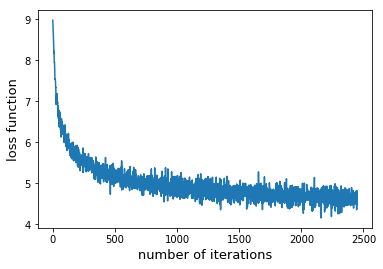

In [155]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# plot loss as a function of iteration
with PdfPages('loss_history.pdf') as pdf:
    plt.plot(loss_history)
    plt.xlabel('number of iterations', fontsize = 13)
    plt.ylabel('loss function', fontsize = 13)
    pdf.savefig()
    plt.show()

In [125]:
def multisvm_predict(W, X):
    Z = X.dot(W)
    return np.argmax(Z, axis=1)

def evaluate(W, X, y):
    y_pred = multisvm_predict(W, X)
    acc = 100*np.mean(y_pred == y)
    return acc 
# y_pred = multisvm_predict(W, X_test)
# acc = 100*np.mean(y_pred == y_test)
# print('training accuracy: %.2f %%' % acc)


In [126]:
lrs = [1e-9, 1e-8, 1e-7, 1e-6]
regs = [0.1, 0.01, 0.001, 0.0001]
best_W = 0
best_acc = 0
for lr in lrs:
    for reg in regs: 
        W, loss_history = multiclass_svm_GD(X_train, y_train, W, reg, \
                                            lr = 1e-8, num_iters = 100, print_every = 1e20)
        acc = evaluate(W, X_val, y_val)
        print('lr = %e, reg = %e, loss = %f, validation acc = %.2f' %(lr, reg, loss_history[-1], acc))
        if acc > best_acc:
            best_acc = acc 
            best_W = W 
            

lr = 1.000000e-09, reg = 1.000000e-01, loss = 4.422479, validation acc = 40.30
lr = 1.000000e-09, reg = 1.000000e-02, loss = 4.474095, validation acc = 40.70
lr = 1.000000e-09, reg = 1.000000e-03, loss = 4.240144, validation acc = 40.90
lr = 1.000000e-09, reg = 1.000000e-04, loss = 4.257436, validation acc = 41.40
lr = 1.000000e-08, reg = 1.000000e-01, loss = 4.482856, validation acc = 41.50
lr = 1.000000e-08, reg = 1.000000e-02, loss = 4.036566, validation acc = 41.40
lr = 1.000000e-08, reg = 1.000000e-03, loss = 4.085053, validation acc = 41.00
lr = 1.000000e-08, reg = 1.000000e-04, loss = 3.891934, validation acc = 41.40
lr = 1.000000e-07, reg = 1.000000e-01, loss = 3.947408, validation acc = 41.50
lr = 1.000000e-07, reg = 1.000000e-02, loss = 4.088984, validation acc = 41.90
lr = 1.000000e-07, reg = 1.000000e-03, loss = 4.073365, validation acc = 41.70
lr = 1.000000e-07, reg = 1.000000e-04, loss = 4.006863, validation acc = 41.80
lr = 1.000000e-06, reg = 1.000000e-01, loss = 3.8517

In [127]:
best_W.shape

(3073, 10)

In [128]:
acc = evaluate(best_W, X_test, y_test)
print('Accuracy on test data = %2f %%'%acc)

Accuracy on test data =  39.88


In [136]:
lrs = [1e-7, 1e-6]
regs = [0.0001, 1e-5, 1e-6]
best_W = 0
best_acc = 0
for lr in lrs:
    for reg in regs: 
        W, loss_history = multiclass_svm_GD(X_train, y_train, W, reg, \
                                            lr = 1e-8, num_iters = 100, print_every = 1e20)
        acc = evaluate(W, X_val, y_val)
        print('lr = %e, reg = %e, loss = %f, validation acc = %.2f' %(lr, reg, loss_history[-1], acc))
        if acc > best_acc:
            best_acc = acc 
            best_W = W 

lr = 1.000000e-07, reg = 1.000000e-04, loss = 4.432414, validation acc = 39.90
lr = 1.000000e-07, reg = 1.000000e-05, loss = 4.110013, validation acc = 40.10
lr = 1.000000e-07, reg = 1.000000e-06, loss = 4.212654, validation acc = 40.80
lr = 1.000000e-06, reg = 1.000000e-04, loss = 4.240339, validation acc = 41.30
lr = 1.000000e-06, reg = 1.000000e-05, loss = 4.295307, validation acc = 41.00
lr = 1.000000e-06, reg = 1.000000e-06, loss = 4.209549, validation acc = 41.20


In [156]:
a = 1
print('%d %%' %a)

1 %
